In [1]:
import os
import pandas as pd
import numpy as np
import glob
import json
import re
from pathlib import Path

import nibabel 
import nilearn

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import mean_img
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

import matplotlib.pyplot as plt
import tracemalloc
import concurrent.futures

/om2/user/rfbrito/miniconda/envs/fmri/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [59]:
has_pop_events = find_populated_events()
has_pop_events[-6]

'/om/project/voice/bids/data/sub-voice976/ses-1/func/sub-voice976_ses-1_task-pataka_run-01_events.tsv'

/om2/user/rfbrito/miniconda/envs/fmri/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


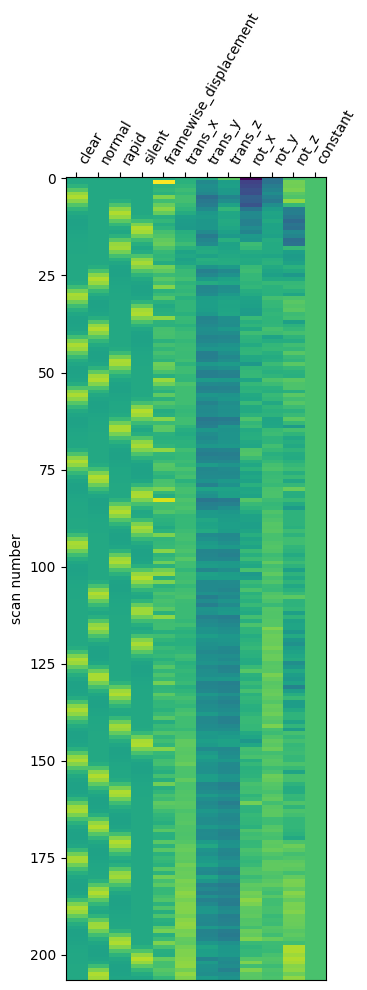

In [60]:
fitted_glm, selected_confounds, nifti = run_first_level_model('voice976','pataka',1,1)
show_design_matrix(fitted_glm)

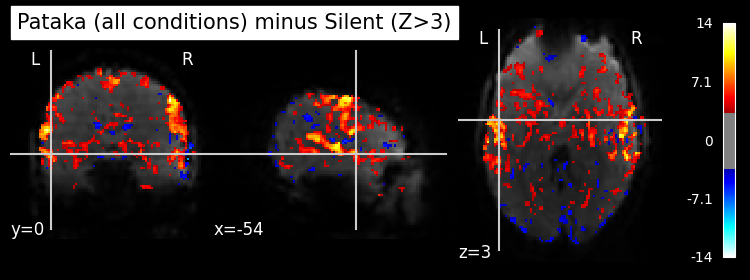

In [61]:
contrast = create_contrast(fitted_glm.design_matrices_[0],'pataka')
zmap = create_zmap(fitted_glm,contrast)

avg_img = mean_img(nifti)

coord = [-54,0,3]

plot_stat_map(zmap, bg_img=avg_img, threshold=3.5,
              display_mode='ortho', cut_coords=coord,
              black_bg=True,
              title='Pataka (all conditions) minus Silent (Z>3)')
plt.show()

In [ ]:
def find_populated_events():
    task='pataka'
    all_events = !ls /om/project/voice/bids/data/sub-voice*/ses-*/func/*{task}*events.tsv

    has_pop_events = [f for f in all_events if pd.read_table(f).shape[0]>0]
    
    return has_pop_events

In [31]:
#get confounds for any subject and task

def get_confounds(sub,task,ses,run):

    all_confounds = pd.read_csv(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.tsv", sep = '\t')
    
    all_confounds_json = open(f"../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-confounds_timeseries.json")
    all_confounds_json=json.load(all_confounds_json)
    
    
    #typically included rigid body motion (or those plus squares and derivatives if desired, then must comment out top line and uncomment bottom 3)
    motion_params = ['trans_x', 'trans_y', 'trans_z','rot_x','rot_y','rot_z']
    # motion_trans_params = [col for col in all_confounds.columns if 'trans' in col] #change to these squares and derivatives if desired
    # motion_rot_params = [col for col in all_confounds.columns if 'rot' in col] #change to these if desired
    # motion_params=motion_trans_params+motion_rot_params #change to these if desired

    
    #individual col with single 1 for timepoint of motion
    #motion_outliers = [col for col in all_confounds.columns if 'motion_outlier' in col]  
    
    
    #for low freq signal drift
    #cannot include this and high-pass temp filter bc already removes low freq fluc
    #required if using aCompCor (or tCompCor)
    #cosine_regressors = [col for col in all_confounds.columns if 'cosine' in col] 
    
    
    #these can be adjusted to be from the combined wm csf, for example
    #doesn't make sense to use csf and wm signal regression if using these according to fmriprep documentation
    #6 is rule of thumb; can pick diff number or specific amount of variance explained
    #TO DO clarify if edge/crown regressors are already part of compcor -- unclear in docs and can't find separate regressor in tsv
    #num_a_comp_cors=6
    #a_comp_cors = []
    #for i in range(num_a_comp_cors):
    #    a_comp_cors.append('a_comp_cor_{:02d}'.format(i))
    
        
    #if taking ICA AROMA denoised niftis (~desc-smoothAROMAnonaggr_bold.nii.gz), can't also include ICA noise regressors & MUST drop non-steady state vols
    #here we are taking instead the ICA AROMA regressors: aroma_motion_XX
    #aroma_regressors_all = [col for col in all_confounds.columns if 'aroma' in col]
    #aroma_regressors_noise=[]
    #TO DO: excluding for now, but double check on this!
#     for regr in aroma_regressors_all:
#         json_name ='aroma_motion_'+str(int(regr.split('aroma_motion_')[1]))
#         if all_confounds_json[json_name]['MotionNoise']==True:
#             aroma_regressors_noise.append(regr)
        

    #we need to filter out non-steady state volumes if using cosine regressors, ICA AROMA and CompCor regressors...    
    #non_steady_state_regressors = [col for col in all_confounds.columns if 'non_steady_state' in col]
           
    #TO DO: not sure if CSF should be kept since already have aCompCors (excluding for now)
    #selected_confounds = all_confounds[['framewise_displacement']+motion_params+motion_outliers+cosine_regressors+a_comp_cors+aroma_regressors_noise+non_steady_state_regressors].copy()

    selected_confounds = all_confounds[['framewise_displacement']+motion_params].copy()

    #get rid of nas in first row of derivative and framewise displacement cols
    for col in selected_confounds.columns:
        if ('derivative' in col) or ('framewise_displacement' in col):
            if pd.isna(selected_confounds[col][0]):
                selected_confounds[col][0]=0

    return selected_confounds



In [51]:
#first level glm model


def run_first_level_model(sub,task,ses,run):
    #memory = './nilearn_cache' #change if desired
    space='MNI152NLin6Asym' #change if desired
    
    task_json = open(f"../../task-{task}_bold.json")
    task_json=json.load(task_json)
    TR=task_json['RepetitionTime']
    
    nifti = glob.glob(f'../../derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*preproc*nii.gz')[0]
    events = glob.glob(f'/om/project/voice/bids/data/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-0{run}*events.tsv')[0]
    
    'voice*/ses-*/func/*{task}*events.tsv'
    #mask = glob.glob(f'../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*run-{run}*{space}*brain_mask.nii.gz')[0]

    selected_confounds=get_confounds(sub,task,ses,run)

    #choose middle slice as reference since fmriprep default for slice timing correction
    #already accounting for drift and high pass filter with cosine regressors (I believe)
    #might want to change to this at some point: minimize_memory=False
    #spm + derivative + disperson should account for undershoot and slight variances in HRF across ppl/regions
    #satra: twice the voxel resolution, so probs 4
    #satra: signal_scaling look more into it, doesn't affect stats but does affect effect size 
    glm = FirstLevelModel(t_r=TR,
                           noise_model='ar1',
                           drift_model=None,
                           standardize=False,
                           hrf_model='spm',
                           high_pass=.01)
        #t_r = TR, #mask_img=mask,
        #slice_time_ref=0.5, smoothing_fwhm=6.0, hrf_model='spm + derivative + dispersion', drift_model=None,
        #high_pass=None, drift_order=4, standardize=False, signal_scaling=False, noise_model='ar1',
        # minimize_memory=True, verbose=0, n_jobs=-2)
    #memory=memory,

    fitted_glm = glm.fit(nifti, events=events, confounds=selected_confounds)

    return [fitted_glm, selected_confounds, nifti]


In [8]:
#plot design matrix for one subject
#not needed to be run unless one wants to see it

def show_design_matrix(fitted_glm):
    for design_matrix in fitted_glm.design_matrices_:
        plot_design_matrix(design_matrix)
        plt.show()

In [11]:

def create_contrast(design_matrix, task):
    #fmri_img = concat_imgs(nifti)
    #mean_img = mean_img(fmri_img)
    
    if task == 'pataka':
        clear = np.zeros(design_matrix.shape[1])
        clear[0] = 1
        normal = np.zeros(design_matrix.shape[1])
        normal[1] = 1
        rapid = np.zeros(design_matrix.shape[1])
        rapid[2] = 1
        silent = np.zeros(design_matrix.shape[1])
        silent[3] = 1


        conditions = {
            'clear': clear,
            'normal': normal,
            'rapid': rapid,
            'silent': silent
        }

        speech_contrast = 0.33*conditions['clear'] + 0.33*conditions['normal'] + 0.33*conditions['rapid'] - conditions['silent']
    
    return speech_contrast

#plot_contrast_matrix(active_minus_rest, design_matrix=design_matrix)
    

In [ ]:
def create_zmap(fitted_glm, speech_contrast):
    
    zmap = fitted_glm.compute_contrast(speech_contrast,
                                  output_type='z_score')
    
    return zmap

In [5]:
#create all desired contrasts

#satra: combine image and arrow regressors because highly collinear!!! can do a correlation matrix of all regressors of design matrix to see if we need to throw out a contrast/subject (anything >0.3 or 0.4 is a high correlation)
#on second thought might be ok to keep them apart

def make_localizer_contrasts(design_matrix,task,selected_confounds):
    """ returns a dictionary of contrasts, given the design matrix"""

    # first generate canonical contrasts based on the design matrix columns 
    contrast_matrix = np.eye(design_matrix.shape[1])
    canonical_contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    
    
    #initialize dictionary of contrasts desired for analysis of respective task
    final_contrasts={}
    
    #initialize list of complex contrasts, which are combinations of the canonical contrasts
    task_contrasts = []
    
    #complex contrasts for nback task (must include a '-' or '+' and be made up of canonical contrasts)
    if task == 'nback':
        task_contrasts = ['twoback-zeroback']
    
    #complex contrasts for mid task (must include a '-' or '+' and be made up of canonical contrasts)
    if task == 'mid':
        task_contrasts = ['HiRewCue-NeuCue', #high reward anticipation
                          'LoRewCue-NeuCue', #low reward anticipation
                          'HiLossCue-NeuCue', #high loss anticipation
                          'LoLossCue-NeuCue', #low loss anticipation
                          
                          'HiWin-NeuHit', #high reward outcome cp. to neutral hit
                          'LoWin-NeuHit', #low reward outcome cp. to neutral hit
                          'HiWin-HiNoWin', #high reward outcome cp. to high reward miss
                          'LoWin-LoNoWin', #low reward outcome cp. to low reward miss
                          
                          'HiLoss-NeuMiss', #high loss cp. to neutral miss
                          'LoLoss-NeuMiss', #low loss cp. to neutral miss
                          'HiLoss-AvoidHiLoss', #high loss cp. to avoid high loss
                          'LoLoss-AvoidLoLoss', #low loss cp. to avoid low loss
                          
                          'HiRewCue+LoRewCue-NeuCue', #combined reward anticipation
                          'HiLossCue+LoLossCue-NeuCue', #combined loss anticipation
                          
                          'HiWin+LoWin-NeuHit', #combined reward outcome cp. to neutral hit
                          'HiWin+LoWin-HiNoWin-LoNoWin', #combined reward outcome cp. to combined reward miss
                          
                          'HiLoss+LoLoss-NeuMiss', #combined loss cp. to neutral miss
                          'HiLoss+LoLoss-AvoidHiLoss-AvoidLoLoss' #combined loss cp. to combined avoid loss  
                         ]
    
    #complex contrasts for sst task (must include a '-' or '+' and be made up of canonical contrasts)
    #TO DO: need to add contrasts to capture comparison between MJ trial and Neutral trial for arrow/stop 
    #TO DO: need to add contrasts to capture comparison between MJ trial and Neutral trial for images
#     if task == 'sst':
#         print('here')
#         task_contrasts = ['N_SuccStop_arrow-N_Go_arrow', #correct inhibition normal
#                           'MJ_SuccStop_arrow-MJ_Go_arrow', #correct inhibition MJ
#                           'N_UnsuccStop_arrow-N_Go_arrow', #incorrect inhibition normal
#                           'MJ_UnsuccStop_arrow-MJ_Go_arrow', #incorrect inhibition MJ
#                           'N_UnsuccStop_arrow-N_SuccStop_arrow', #successful inhibitory control normal
#                           'MJ_UnsuccStop_arrow-MJ_SuccStop_arrow' #successful inhibitory control MJ
#                          ]
    
    #for loop that creates complex contrasts based on the string names from the task_contrasts list created above
    for task_contrast in task_contrasts:
        #split complex contrast string into a list of canonical contrasts separated by '-' or '+' 
        #'-' and '+' are maintained in the list due to the () around the deliminator specified in re.split
        events = re.split('([\-\+])', task_contrast)
        
        #check if all canonical contrasts needed for a given complex contrast were present in a subject's data
        #note that sometimes a participant eg. never had a miss on a type of trial, so the miss regressor doesn't exist 
        #can comment out print statements to see which contrasts are being generated vs. for which events are missing
        if len(set(events).intersection(set(canonical_contrasts.keys()))) < np.ceil(len(events)/2):
            #print(f'issue with: {task_contrast}')
            continue
        #print(f'checking passed for {task_contrast}')
        
        #set up placeholder for array containing matrix for the complex contrast
        complex_contrast = 0
        #set up how the canonical contrasts will be added/subtracted to create the complex contrast
        math_sign = '+'
        plus_multiplier = 1
        minus_multiplier = 1
        #this only applies to the mid task, since the nback and sst tasks' complex contrasts are only made up of two canonical contrasts
        #if mid list consists of 5 elements (i.e. 3 canonical contrasts and 2 math symbols), there is always 1 '+' and 1 '-' (in addition to the implied '+ at the beginning)
        #in that case, we need to multiply the 2 canonical constrasts after the '+' and implied '+' by 0.5
        if len(events) == 5:
            plus_multiplier = 0.5
        #if mid list consists of 7 elements (i.e. 4 canonical contrasts and 3 math symbols), there is always 1 '+' and 2 '-' (in addition to the implied '+ at the beginning)
        #in that case, we need to multiply the 4 canonical constrasts by 0.5
        if len(events) == 7:
            minus_multiplier = 0.5
            plus_multiplier = 0.5
            
        #do the complex contrast calculation
        for el in events:
            #math_sign starts of with '+' as set up above since the first canonical contrast has an implied '+' at the beginning (added to the 0 that we used to initialize the complex contrast)
            if el in ['+','-']:
                math_sign = el
            #if current list element isn't a math sign, then it's a canonical contrast and we add/subtract based on the math sign we set
            #we also multiply the canonical contrast by 1 (default) or 0.5 (certain mid complex contrasts)
            else:
                if math_sign == '+':
                    complex_contrast = complex_contrast + plus_multiplier*canonical_contrasts[el]
                if math_sign == '-':
                    complex_contrast = complex_contrast - minus_multiplier*canonical_contrasts[el]
        #at the end we store the created complex contrast        
        final_contrasts[task_contrast] = complex_contrast       
                
        
    #add a nuisance regressor contrast to the final set of contrasts that includes all nuisance regressors
    #firs set up zeros matrix of correct shape
    final_contrasts['nuisance_regressors']=np.zeros(design_matrix.shape[1])
    #this iteratively adds a 1 in place of all the confounds in the zeros matrix
    for confound in selected_confounds.columns:
        final_contrasts['nuisance_regressors']=final_contrasts['nuisance_regressors']+canonical_contrasts[confound]
    
    #return dictionary of all complex contrasts
    return final_contrasts


In [6]:
#loop over all subjects to store first level GLM results

def save_first_level_outputs(input_list):
    sub,task,ses,run = input_list
    print(f'Now processing subject {sub} for task {task} in session {ses} run {run}')
    
    #check that input exists
    nifti = glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz')
    if not nifti: #checks if list is empty
        print(f'1st level input does not exist for subject {sub}, session {ses}, run {run} and task {task}. Cannot generate output.')
        return
    
    #check that output does not exist
    output = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-*_effect_size.nii.gz')
    if output: #checks if list is not empty
        print(f'At least partial 1st level output exists for subject {sub}, session {ses}, run {run} and task {task}. This must be deleted for before generating new output.')
        return    
    
    #run first level model 
    #note confounds are subject specific! 
    fitted_glm, selected_confounds = run_first_level_model(sub,task,ses,run)         
    
    #define contrasts for task
    #note constrasts are subject specific due to varying numbers of confounders        
    contrasts = make_localizer_contrasts(fitted_glm.design_matrices_[0],task,selected_confounds)

    for contrast in contrasts.keys():
        #calculate contrast maps for all contrasts
        #satra: f test for all nuisance regressors and look at map to see what areas are affected 
        #TO DO: F is a 2D contrast, so unclear if that makes sense/works if nuisance contrast is 1D array
        #F usually means is any of these 1D contrasts significant?
        #can also just not set stat_type and will default to t or F, depending on dim of contrast
        if contrast == 'nuisance_regressors':
            contrast_output = fitted_glm.compute_contrast(contrasts[contrast], output_type='all',stat_type='F')
        else:   
            contrast_output = fitted_glm.compute_contrast(contrasts[contrast], output_type='all',stat_type='t')
        
        #create paths to output dir if not exist
        derivatives_path = '../../../derivatives'
        nilearn_output_path = os.path.join(derivatives_path, 'nilearn','first_level',f'sub-{sub}',f'ses-{ses}',f'task-{task}')
        if not os.path.isdir(nilearn_output_path):
            os.makedirs (nilearn_output_path)
            
        #save contrast maps to files
        contrast_output['effect_size'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_effect_size.nii.gz')
        contrast_output['effect_variance'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_effect_variance.nii.gz')
        contrast_output['z_score'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_z_score.nii.gz')
        contrast_output['stat'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_stat.nii.gz')
        contrast_output['p_value'].to_filename(f'../../../derivatives/nilearn/first_level/sub-{sub}/ses-{ses}/task-{task}/sub-{sub}_ses-{ses}_task-{task}_rec-unco_run-{run}_contrast-{contrast}_p_value.nii.gz')
    
    return
    

In [14]:
#select runs, tasks and sessions to process
#task_list=['sst','nback','mid']
#task_list=['nback','mid'] #since sst contrast isn't finalized
#ses_list=['baseline','1year']
#run_list=['1','2','3']

task_list=['nback']
ses_list=['baseline','1year']
run_list=['1','2','3']


# for task in task_list:
#     for ses in ses_list:
#         for run in run_list:
#             #find all subjects who have task niftis and events.tsv for this task, session & run
#             space='MNI152NLin6Asym' #change if desired
#             nifti = (glob.glob(f'../../../derivatives/ses-{ses}/sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz'))
#             subjs_nifti = set([path.split(f'/ses-{ses}/')[1].split('-')[-1] for path in nifti])
#             events = (glob.glob(f'../../../sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*events.tsv'))
#             subjs_events = set([path.split(f'/ses-{ses}/')[0].split('-')[-1] for path in events if pd.read_csv(path).shape[0] != 0])
#             subjs = list(subjs_nifti.intersection(subjs_events))
#             for sub in subjs:
#                 if sub == 'MM273':
#                 #TO DO: this will become input to the script
#                 #if sub not in ['MM086','MM273']: #for 1year, run1: missing NeuMiss, NeuHit, respectively
#                 #if sub not in ['MM254','MM273']: #for 1year, run2: missing HiLoss, NeuHit, respectively
#                 #if sub not in ['HC023','HC035','MM254','MM283']:  #for baseline, run1: HC023 doesn't have NeuMiss; HC035 doesn't have NeuHit; MM254 doesn't have HiWin; MM283 doesn't have NeuMiss
#                 #if sub not in ['HC009','HC013','HC020','HC023','MM147','MM197','MM199','MM254','MM340']: #for baseline, run2: HC009 is missing NeuHit, HC013 is missing NeuHit; HC020 is missing HiNoWin;HC023 is missing HiLoss; MM147 is missing HiLoss; MM197 is missing NeuHit; MM199 is missing HiLoss; MM254 is missing HiWin; MM340 is missing NeuHit
#                 #if sub:
#                     input_list = sub,task,ses,run
#                     save_first_level_outputs(input_list)


inputs = []

for task in task_list:
    for ses in ses_list:
        for run in run_list:
            #find all subjects who have task niftis and events.tsv for this task, session & run
            space='MNI152NLin6Asym' #change if desired
            nifti = (glob.glob(f'../../../derivatives/ses-{ses}/sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*{space}*preproc*nii.gz'))
            subjs_nifti = set([path.split(f'/ses-{ses}/')[1].split('-')[-1] for path in nifti])
            events = (glob.glob(f'../../../sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-{run}*events.tsv'))
            subjs_events = set([path.split(f'/ses-{ses}/')[0].split('-')[-1] for path in events if pd.read_csv(path).shape[0] != 0])
            subjs = list(subjs_nifti.intersection(subjs_events))
            
            for sub in subjs:
                inputs.append([sub,task,ses,run])


# starting the monitoring
tracemalloc.start()

print(len(inputs))
n=20
input_chunks = [inputs[i::n] for i in range(n)]

with concurrent.futures.ProcessPoolExecutor() as executor:
    for input_chunk in input_chunks:
        for single_input, prime in zip(input_chunk, executor.map(save_first_level_outputs, input_chunk)):
            print(' '.join(single_input) + ': processing done')
executor.shutdown()

# displaying the memory
print(tracemalloc.get_traced_memory())
 
# stopping the library
tracemalloc.stop()

        

59
Now processing subject MM096 for task nback in session 1year run 1
Now processing subject MM334 for task nback in session 1year run 1Now processing subject MM100 for task nback in session 1year run 1

At least partial 1st level output exists for subject MM096, session 1year, run 1 and task nback. This must be deleted for before generating new output.
At least partial 1st level output exists for subject MM100, session 1year, run 1 and task nback. This must be deleted for before generating new output.At least partial 1st level output exists for subject MM334, session 1year, run 1 and task nback. This must be deleted for before generating new output.

Now processing subject MM315 for task nback in session 1year run 1
Now processing subject MM054 for task nback in session 1year run 1Now processing subject MM148 for task nback in session 1year run 1

At least partial 1st level output exists for subject MM315, session 1year, run 1 and task nback. This must be deleted for before generating

In [ ]:
#TO DO: ADJUST START TIME???

In [ ]:
 #load all the events.tsv file as dataframes and then add columns for each label
    #events_w_metadata_all = []
    #for f in Path('../data/counts_pataka/').glob('*'):
    #import re
#re.split('_',name)
#     test = !ls /om/project/voice/bids/data/sub-voice*/ses-*/func/*pataka*events.tsv
# df = pd.read_table(test[0])
# name = str(Path(test[0]).stem)
# name.split('_')[1].split['-'][1]
#     for f in all_events:
#         #df = pd.read_csv(f,sep='\t')
#         df = pd.read_table(f)
#         if df.shape[0]>0:
#             name = str(Path(f).stem)
#             subj = name.split('_')[0]
#             ses = name.split('_')[1]
#             task = name.split('task_')[2]
#             run = name.split('_0')[3]
        
#             has_pop_events.append(f)
            #df['subj'] = [name.split('_')[0]] * df.shape[0]
            #df['ses'] = [name.split('_')[1]] * df.shape[0]
            #df['task'] = [name.split('_')[2]] * df.shape[0]
            #df['run'] = [name.split('_')[3]] * df.shape[0]
            #events_w_metadata_all.append(df)

    #only keep ones that aren't empty to test if same ses/run are the same    
    #populated_events = [c for c in events_w_metadata_all if c.shape[0]>0]